In [1]:
library(randomForest)
library(readr)
library(dplyr)
library(rpart)
library(caret)
library(nnet)
library(vip)

set.seed(42)

data <- read_csv("nsw.csv", show_col_types = FALSE)
categorical_columns <- c(
  "Gender", "Industry", "FamilyStatus",
  "Location",  "ManagingRole", "MentalHealth"
)
numeric_columns <- c(
  "Age", "Experience", "CommuteTimeDiff", "WorkTimeDiff", "HouseworkTimeDiff",
  "FamilyTimeDiff", "RemoteWorkExtent", "RemoteWorkSupport", "Productivity",
  "ReducedPromotion", "SocialIsolation", "SleepTimeDiff", "ExtraCosts",
  "WorkCompatibility", "Motivation", "HomeEnvironment", "Wellbeing",
  "PhysicalActivity", "Sociability"
)

data[categorical_columns] <- lapply(data[categorical_columns], as.factor)
data[numeric_columns] <- lapply(data[numeric_columns], as.numeric)
data[numeric_columns] <- lapply(data[numeric_columns], scale)

head(data)
dim(data)

Warning message:
"package 'randomForest' was built under R version 4.3.3"
randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'dplyr'


The following object is masked from 'package:randomForest':

    combine


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'caret' was built under R version 4.3.3"
Loading required package: ggplot2

Warning message:
"package 'ggplot2' was built under R version 4.3.3"

Attaching package: 'ggplot2'


The following object is masked from 'package:randomForest':

    margin


Loading required package: lattice

Warning message:
"package 'vip' was built under R version 4.3.3"

Attaching package: 'vip'


The following object is masked from 'package:utils':

    vi




Age,Gender,Experience,Industry,FamilyStatus,Location,ReducedPromotion,CommuteTimeDiff,WorkTimeDiff,HouseworkTimeDiff,⋯,Motivation,HomeEnvironment,Wellbeing,MentalHealth,PhysicalActivity,Sociability,ManagingRole,RemoteWorkExtent,RemoteWorkSupport,Productivity
"<dbl[,1]>",<fct>,"<dbl[,1]>",<fct>,<fct>,<fct>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",⋯,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<fct>,"<dbl[,1]>","<dbl[,1]>",<fct>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
0.25489190,male,0.9403261,other_services,couple_with_dependent_children,metro,-1.1175702,-0.61964823,1.3719844,-0.2207096,⋯,-0.166609,0.01176681,1.2139968,3,0.7859694,-0.5502987,no,0.004252265,1.0535760,1.0775389
0.67971175,male,0.9403261,construction,couple_with_no_dependent_children,metro,0.1261208,-0.26621209,1.3719844,1.5534631,⋯,-0.166609,0.01176681,-0.1433854,2,-0.5255189,-0.5502987,no,-1.203391119,-0.5638055,1.0775389
0.08496397,female,-2.0368490,financial_and_insurance,single_person,metro,-1.1175702,-0.61964823,-0.2026512,0.6663767,⋯,1.258600,1.40417235,-0.1433854,3,-0.5255189,-1.9432116,no,1.211895650,1.0535760,-0.4822014
1.44438746,female,-0.5482615,health_care_and_social_assistance,one_parent_family_with_dependent_children,regional,-1.1175702,0.79409634,-0.2026512,-1.9948822,⋯,-1.591818,-1.38063873,-1.5007676,3,0.7859694,0.8426142,yes,0.004252265,-0.5638055,1.0775389
-0.50978381,male,-0.5482615,manufacturing,couple_with_dependent_children,metro,0.1261208,0.08722406,-0.2026512,1.5534631,⋯,-0.166609,0.01176681,-0.1433854,2,-0.5255189,-0.5502987,no,0.004252265,-0.5638055,-0.4822014
0.50978381,male,0.9403261,public_administration_and_safety,couple_with_dependent_children,metro,-1.1175702,0.08722406,-0.2026512,-0.2207096,⋯,1.258600,0.01176681,-0.1433854,3,0.7859694,0.8426142,yes,1.211895650,-0.5638055,-0.4822014


[1] 1420   25

In [2]:
table(data$MentalHealth)


  1   2   3 
155 421 844 

In [3]:
min_class_size <- data %>%
  count(MentalHealth) %>%
  summarise(min_size = min(n)) %>%
  pull(min_size)

# Undersample all classes to the smallest class size
data <- data %>%
  group_by(MentalHealth) %>%
  slice_sample(n = min_class_size) %>%
  ungroup()

table(data$MentalHealth)


  1   2   3 
155 155 155 

In [4]:
train_index <- createDataPartition(data$MentalHealth, p = 0.8, list = FALSE)
train_data <- data[train_index, ]
test_data <- data[-train_index, ]

table(train_data$MentalHealth)
table(test_data$MentalHealth)


  1   2   3 
124 124 124 


 1  2  3 
31 31 31 

In [5]:
model <- multinom(MentalHealth ~ ., data = train_data, maxit = 500)
predicted_classes <- predict(model, test_data, type = "class")

conf_matrix <- confusionMatrix(
  factor(predicted_classes, levels = levels(test_data$MentalHealth)),
  test_data$MentalHealth
)
conf_matrix

# weights:  144 (94 variable)
initial  value 408.683771 
iter  10 value 286.574853
iter  20 value 262.762700
iter  30 value 257.981611
iter  40 value 256.137398
iter  50 value 255.058335
iter  60 value 254.459774
iter  70 value 254.332171
iter  80 value 254.129722
iter  90 value 252.656116
iter 100 value 252.653805
iter 110 value 252.210245
iter 120 value 252.199841
final  value 252.199820 
converged


Confusion Matrix and Statistics

          Reference
Prediction  1  2  3
         1 20  9  3
         2  9 13 12
         3  2  9 16

Overall Statistics
                                          
               Accuracy : 0.5269          
                 95% CI : (0.4206, 0.6314)
    No Information Rate : 0.3333          
    P-Value [Acc > NIR] : 9.324e-05       
                                          
                  Kappa : 0.2903          
                                          
 Mcnemar's Test P-Value : 0.8899          

Statistics by Class:

                     Class: 1 Class: 2 Class: 3
Sensitivity            0.6452   0.4194   0.5161
Specificity            0.8065   0.6613   0.8226
Pos Pred Value         0.6250   0.3824   0.5926
Neg Pred Value         0.8197   0.6949   0.7727
Prevalence             0.3333   0.3333   0.3333
Detection Rate         0.2151   0.1398   0.1720
Detection Prevalence   0.3441   0.3656   0.2903
Balanced Accuracy      0.7258   0.5403   0.6694

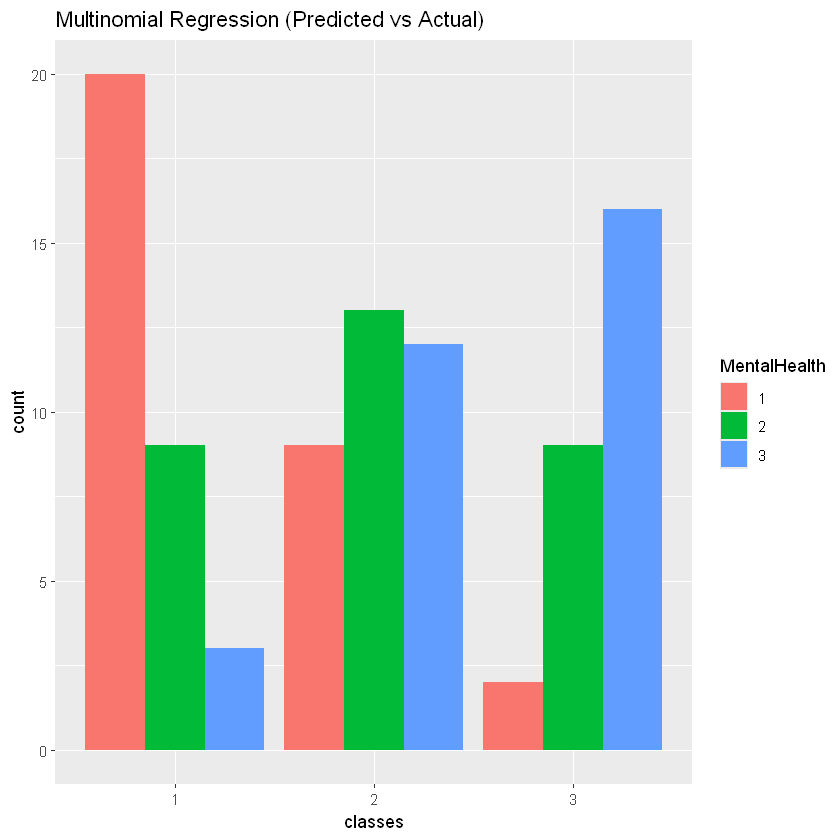

In [6]:
ggplot(data = test_data, aes(x = predicted_classes, fill = MentalHealth)) +
  geom_bar(position = "dodge") +
  labs(title = "Multinomial Regression (Predicted vs Actual)") +
  xlab("classes")

In [7]:
coeffs <- summary(model)$coefficients
std_err <- summary(model)$standard.errors

z_values <- coeffs / std_err
p_values <- 2 * (1 - pnorm(abs(z_values)))

result_table <- as.data.frame(coeffs) %>%
  tibble::rownames_to_column(var = "Class") %>%
  tidyr::pivot_longer(
    cols = -Class,
    names_to = "Variable",
    values_to = "Coefficient"
  ) %>%
  mutate(
    StdError = as.numeric(std_err),
    ZValue = Coefficient / StdError,
    PValue = 2 * (1 - pnorm(abs(ZValue)))
  ) %>%
  filter(PValue < 0.05) %>%
  arrange(PValue)

result_table

Warning message in sqrt(diag(vc)):
"NaNs produced"
Warning message in sqrt(diag(vc)):
"NaNs produced"


Class,Variable,Coefficient,StdError,ZValue,PValue
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
2,(Intercept),-605.7422921,5.072412e-01,-1.194190e+03,0.000000e+00
2,Industryadministrative_and_support,607.4868958,3.644592e-01,1.666817e+03,0.000000e+00
2,Industryagriculture_forestry_and_fishing,608.7191229,4.368245e-01,1.393509e+03,0.000000e+00
2,Industryarts_and_recreation,607.9207175,1.857825e-01,3.272218e+03,0.000000e+00
2,Industryconstruction,609.7183418,2.155943e-01,2.828083e+03,0.000000e+00
2,Industryeducation_and_training,608.6995379,7.945912e-01,7.660538e+02,0.000000e+00
2,Industryelectricity_gas_water_and_waste,608.7384367,1.531214e+00,3.975529e+02,0.000000e+00
2,Industryfinancial_and_insurance,607.6774940,1.521007e+00,3.995231e+02,0.000000e+00
2,Industryhealth_care_and_social_assistance,608.1875972,2.162748e+00,2.812106e+02,0.000000e+00


In [8]:
rf_model <- randomForest(MentalHealth ~ ., data = train_data)
rf_predictions <- predict(rf_model, test_data)
rf_conf_matrix <- confusionMatrix(rf_predictions, test_data$MentalHealth)
rf_conf_matrix

Confusion Matrix and Statistics

          Reference
Prediction  1  2  3
         1 21  6  4
         2  7 19  8
         3  3  6 19

Overall Statistics
                                          
               Accuracy : 0.6344          
                 95% CI : (0.5281, 0.7319)
    No Information Rate : 0.3333          
    P-Value [Acc > NIR] : 2.855e-09       
                                          
                  Kappa : 0.4516          
                                          
 Mcnemar's Test P-Value : 0.9177          

Statistics by Class:

                     Class: 1 Class: 2 Class: 3
Sensitivity            0.6774   0.6129   0.6129
Specificity            0.8387   0.7581   0.8548
Pos Pred Value         0.6774   0.5588   0.6786
Neg Pred Value         0.8387   0.7966   0.8154
Prevalence             0.3333   0.3333   0.3333
Detection Rate         0.2258   0.2043   0.2043
Detection Prevalence   0.3333   0.3656   0.3011
Balanced Accuracy      0.7581   0.6855   0.7339

In [9]:
importance_table <- as.data.frame(importance(rf_model))

importance_table <- importance_table %>%
  tibble::rownames_to_column(var = "Variable") %>%
  arrange(desc(MeanDecreaseGini))

print(importance_table)

            Variable MeanDecreaseGini
1   PhysicalActivity        35.506735
2           Industry        27.994072
3                Age        16.335788
4       FamilyStatus        15.279049
5       Productivity        14.708899
6    CommuteTimeDiff        12.753877
7     FamilyTimeDiff        10.479910
8  RemoteWorkSupport         9.714800
9        Sociability         9.616798
10 HouseworkTimeDiff         9.437964
11         Wellbeing         8.663507
12      WorkTimeDiff         8.622696
13   HomeEnvironment         7.629865
14  RemoteWorkExtent         7.490589
15     SleepTimeDiff         7.079501
16        Motivation         7.012818
17  ReducedPromotion         6.997775
18        Experience         5.859547
19        ExtraCosts         5.514163
20 WorkCompatibility         5.137281
21   SocialIsolation         4.985063
22            Gender         4.032625
23      ManagingRole         3.167457
24          Location         2.182712


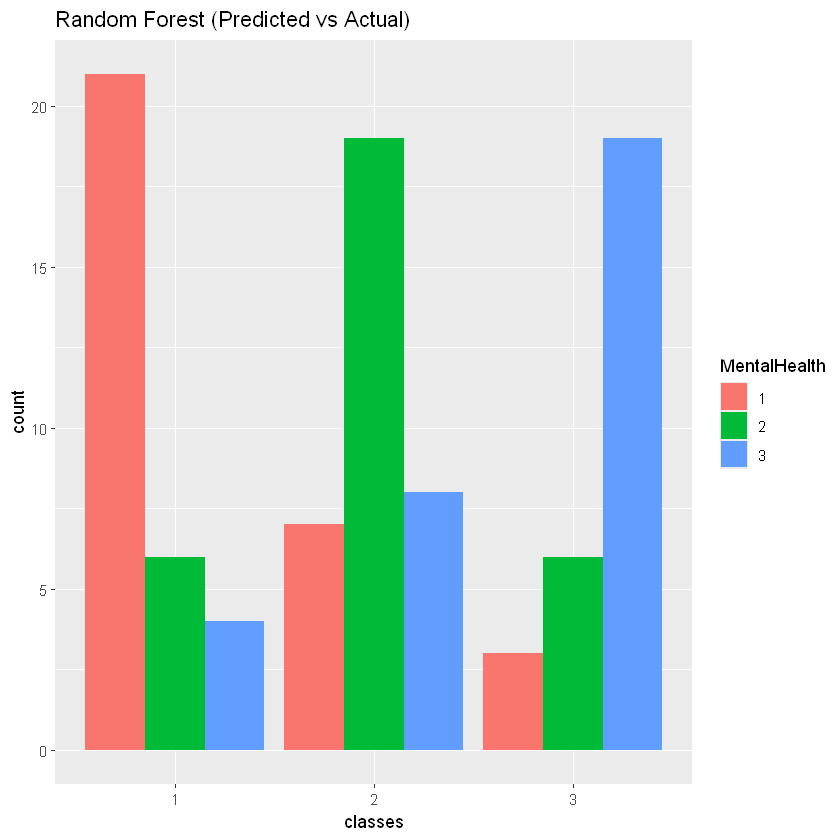

In [10]:
ggplot(data = test_data, aes(x = rf_predictions, fill = MentalHealth)) +
  geom_bar(position = "dodge") +
  labs(title = "Random Forest (Predicted vs Actual)") +
  xlab("classes")